In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
!pip install rasterio

In [ ]:
!pip install whitebox

In [ ]:
import os
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import tifffile as tiff
import cv2
import torch
import os
import pandas as pd
import rasterio
import seaborn as sns
import plotly.express as px
import whitebox

from tensorflow import keras
from tensorflow.keras import layers
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, mean_absolute_error, mean_squared_error, r2_score
from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from sklearn.svm import SVC
from sklearn.naive_bayes import GaussianNB
from sklearn.model_selection import GridSearchCV, cross_val_score, KFold

In [ ]:
DEM_FOLDER = "/content/drive/My Drive/NU/data"
LABEL_FILE = "labels.csv"

In [ ]:
import os
import rasterio
import numpy as np
import whitebox

wbt = whitebox.WhiteboxTools()
wbt.verbose = True  # Turn on to debug failures

def extract_features(dem_path):
    # Ensure absolute paths for WBT
    dem_path = os.path.abspath(dem_path)
    temp_dir = os.path.abspath("wbt_temp")
    os.makedirs(temp_dir, exist_ok=True)

    filled_path = os.path.join(temp_dir, "filled.tif")
    slope_path = os.path.join(temp_dir, "slope.tif")
    flowacc_path = os.path.join(temp_dir, "flow_acc.tif")
    temp_dem_path = os.path.join(temp_dir, "input_dem.tif")

    # Load DEM and replace NaNs for processing
    with rasterio.open(dem_path) as src:
        dem = src.read(1).astype(float)
        dem = np.where(dem == src.nodata, np.nan, dem)
        dem_filled = np.where(np.isnan(dem), np.nanmean(dem), dem)

        profile = src.profile
        profile.update(dtype=rasterio.float32, count=1)

        # Write DEM for WBT
        with rasterio.open(temp_dem_path, 'w', **profile) as dst:
            dst.write(dem_filled.astype(np.float32), 1)

    # --- Hydrological processing ---
    wbt.fill_depressions(temp_dem_path, filled_path)

    if not os.path.exists(filled_path):
        raise FileNotFoundError(f"Whitebox failed to create {filled_path}")

    wbt.slope(filled_path, slope_path, zfactor=1.0)
    if not os.path.exists(slope_path):
        raise FileNotFoundError(f"Whitebox failed to create {slope_path}")

    wbt.d8_flow_accumulation(filled_path, flowacc_path, out_type="cells")
    if not os.path.exists(flowacc_path):
        raise FileNotFoundError(f"Whitebox failed to create {flowacc_path}")

    # Load slope and flow accumulation
    with rasterio.open(slope_path) as s:
        slope = s.read(1)
    with rasterio.open(flowacc_path) as f:
        flow_accum = f.read(1)

    # Calculate features
    features = {
        'mean_elevation': np.nanmean(dem),
        'std_elevation': np.nanstd(dem),
        'min_elevation': np.nanmin(dem),
        'max_elevation': np.nanmax(dem),
        'range_elevation': np.nanmax(dem) - np.nanmin(dem),
        'elevation_25_percentile': np.nanpercentile(dem, 25),
        'elevation_75_percentile': np.nanpercentile(dem, 75),
        'mean_slope': np.nanmean(slope),
        'max_slope': np.nanmax(slope),
        'mean_flow_accum': np.nanmean(flow_accum),
        'max_flow_accum': np.nanmax(flow_accum),
        'percent_low_slope': np.sum(slope < 2) / slope.size
    }

    return features

In [ ]:
# --- Load labels ---
labels_df = pd.read_csv(LABEL_FILE)

# --- Extract features for each DEM ---
records = []
for idx, row in labels_df.iterrows():
    filename = row['filename']
    label = row['label']
    filepath = os.path.join(DEM_FOLDER, filename)

    if os.path.exists(filepath):
        try:
            features = extract_features(filepath)
            features['filename'] = filename
            features['label'] = label
            records.append(features)
        except rasterio.errors.RasterioIOError as e:
            print(f"Error processing file {filepath}: {e}")
            print(f"Skipping file: {filepath}")
    else:
        print(f"Missing file: {filepath}")

# --- Convert to DataFrame ---
data_df = pd.DataFrame(records)

Streaming output truncated to the last 5000 lines.
Fixing flats: 72%
Fixing flats: 73%
Fixing flats: 74%
Fixing flats: 75%
Fixing flats: 76%
Fixing flats: 77%
Fixing flats: 78%
Fixing flats: 79%
Fixing flats: 80%
Fixing flats: 81%
Fixing flats: 82%
Fixing flats: 83%
Fixing flats: 84%
Fixing flats: 85%
Fixing flats: 86%
Fixing flats: 87%
Fixing flats: 88%
Fixing flats: 89%
Fixing flats: 90%
Fixing flats: 91%
Fixing flats: 92%
Fixing flats: 93%
Fixing flats: 94%
Fixing flats: 95%
Fixing flats: 96%
Fixing flats: 97%
Fixing flats: 98%
Fixing flats: 99%
Fixing flats: 100%
Saving data...
Output file written
Elapsed Time (excluding I/O): 8.356s
./whitebox_tools --run="Slope" --dem='/content/wbt_temp/filled.tif' --output='/content/wbt_temp/slope.tif' --zfactor='1.0' --units=degrees -v --compress_rasters=False

****************************
* Welcome to Slope         *
* Powered by WhiteboxTools *
* www.whiteboxgeo.com      *
****************************
Progress: 0%
Progress: 1%
Progress: 2%
Pr

In [ ]:
data_df.head()

,mean_elevation,std_elevation,min_elevation,max_elevation,range_elevation,elevation_25_percentile,elevation_75_percentile,mean_slope,max_slope,mean_flow_accum,max_flow_accum,percent_low_slope,filename,label
0,4.796266,2.090364,-23.759979,30.815924,54.575903,3.451903,5.950454,1.120739,17.932409,858.146423,626955.0,0.831483,mahalla.tif,0
1,254.860024,92.513596,11.052102,501.574097,490.521995,196.639359,322.735260,1.120739,17.932409,858.146423,626955.0,0.831483,newCairo.tif,0
2,2.273806,2.127462,-17.847256,15.310975,33.158231,0.884242,3.633660,1.120739,17.932409,858.146423,626955.0,0.831483,newDamietta.tif,0
3,9.805417,7.539012,-37.370491,50.808865,88.179356,4.956261,11.863695,1.120739,17.932409,858.146423,626955.0,0.831483,salhya.tif,0
4,8.023023,2.178843,-10.607177,28.935760,39.542937,6.588211,9.245791,1.120739,17.932409,858.146423,626955.0,0.831483,tanta.tif,0


In [ ]:
data_df.isnull().sum()

,0
mean_elevation,0
std_elevation,0
min_elevation,0
max_elevation,0
range_elevation,0
elevation_25_percentile,0
elevation_75_percentile,0
mean_slope,0
max_slope,0
mean_flow_accum,0


In [ ]:
data_df.duplicated().sum()

np.int64(0)

In [ ]:
data_df.drop_duplicates(inplace=True)

In [ ]:
data_df.describe()

,mean_elevation,std_elevation,min_elevation,max_elevation,range_elevation,elevation_25_percentile,elevation_75_percentile,mean_slope,max_slope,mean_flow_accum,max_flow_accum,percent_low_slope,label
count,308.000000,308.000000,308.000000,308.000000,308.000000,308.000000,308.000000,308.000000,308.000000,308.000000,308.00,308.000000,308.000000
mean,752.337081,208.746538,367.657747,1558.011582,1190.353835,593.455617,880.680956,5.319448,60.355305,3663.515381,5828534.50,0.450727,0.620130
std,557.959260,204.510545,334.321534,1112.017077,1015.056552,492.563836,655.501327,3.663690,16.972208,4583.926758,3113961.50,0.209732,0.486144
min,1.124068,1.365950,-397.000000,13.519630,19.493451,-1.642216,0.000000,0.466697,14.749866,447.490295,174337.00,0.065642,0.000000
25%,344.739615,40.495394,68.345327,549.000000,272.500000,232.000000,396.000000,2.290472,48.952753,1911.153687,3567844.00,0.288254,0.000000
50%,566.878920,127.377387,335.500000,1207.500000,744.500000,448.500000,654.000000,4.124463,66.162788,2460.880371,5489895.50,0.466907,1.000000
75%,1124.700841,365.772292,578.750000,2572.000000,2146.750000,897.000000,1304.500000,7.542079,73.298746,3302.136292,7756387.25,0.591191,1.000000
max,2577.619682,884.276952,1589.000000,4201.000000,3629.000000,2354.000000,2905.000000,15.804128,87.786934,40369.253906,12858212.00,0.941345,1.000000


In [ ]:
float_cols = data_df.select_dtypes(include=['float64']).columns
data_df[float_cols] = data_df[float_cols].round(3)

In [ ]:
def show_dem(filepath, title="DEM"):
    with rasterio.open(filepath) as src:
        dem = src.read(1)
        dem = np.where(dem == src.nodata, np.nan, dem)

    plt.figure(figsize=(6, 6))
    plt.imshow(dem, cmap='terrain')
    plt.colorbar(label="Elevation (m)")
    plt.title(title)
    plt.axis('off')
    plt.show()

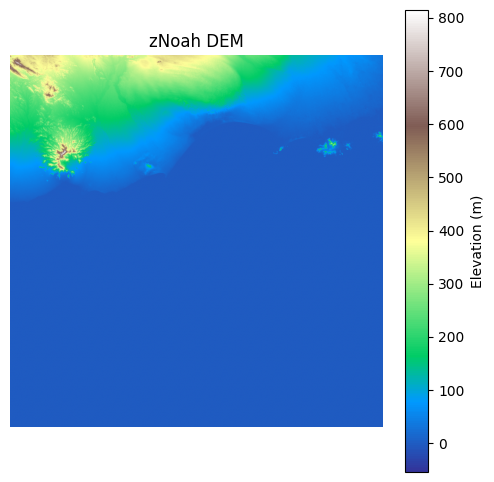

In [ ]:
show_dem("/content/drive/My Drive/NU/data/1.tiff", "zNoah DEM")

Boxplot of Mean Elevation by Class

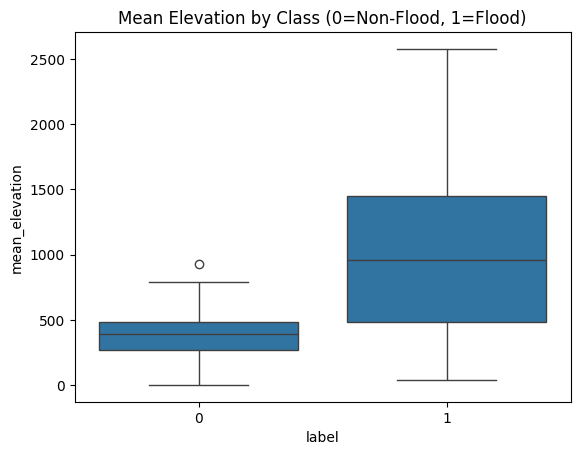

In [ ]:
sns.boxplot(x='label', y='mean_elevation', data=data_df)
plt.title("Mean Elevation by Class (0=Non-Flood, 1=Flood)")
plt.show()

Scatter Plot (e.g., mean vs std elevation)

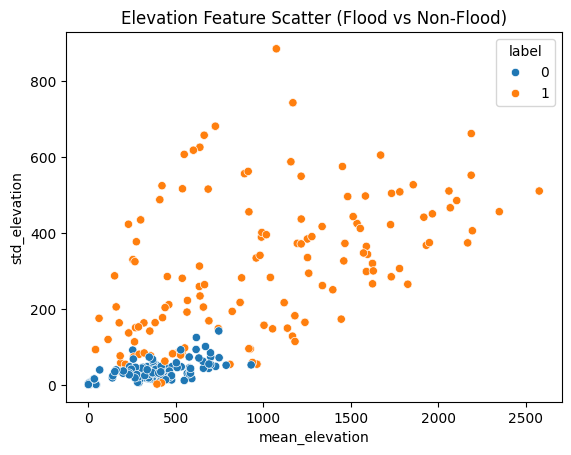

In [ ]:
sns.scatterplot(data=data_df, x='mean_elevation', y='std_elevation', hue='label')
plt.title("Elevation Feature Scatter (Flood vs Non-Flood)")
plt.show()

In [ ]:
# Create histograms to visualize the distribution of the the columns
cols=data_df.columns.drop("filename")
for col in cols:
    fig=px.histogram(data_df, x=col)
    fig.show()

The columns are exponentially distributed -->logarithmic scaling

In [ ]:
# Identify numeric columns excluding 'label'
numeric_cols = data_df.select_dtypes(include=['number']).columns.drop('label')

# Shift values if necessary to avoid negatives
min_val = data_df[numeric_cols].min().min()
if min_val <= -1:
    data_df[numeric_cols] = data_df[numeric_cols] + abs(min_val) + 1

# Apply log1p safely
data_df[numeric_cols] = np.log1p(data_df[numeric_cols])

Heatmap of Feature Correlation

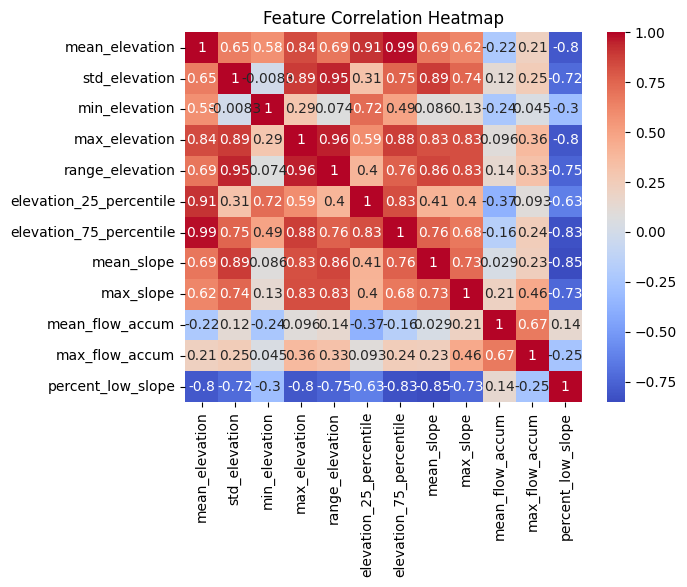

In [ ]:
corr = data_df.drop(columns=["filename", "label"]).corr()
sns.heatmap(corr, annot=True, cmap="coolwarm")
plt.title("Feature Correlation Heatmap")
plt.show()

In [ ]:
# Exclude 'label' from numeric columns to check correlations
columns = data_df.select_dtypes(include=np.number).drop(columns=['label'], errors='ignore')

correlation_matrix = columns.corr()
to_drop = set()

for i in range(len(correlation_matrix.columns)):
    for j in range(i + 1, len(correlation_matrix.columns)):
        if correlation_matrix.iloc[i, j] > 0.85:
            col_to_drop = correlation_matrix.columns[j]
            to_drop.add(col_to_drop)

# Drop highly correlated columns, keeping 'label'
data_df.drop(columns=to_drop, inplace=True)

print("Dropped columns:", to_drop)


Dropped columns: {'elevation_25_percentile', 'mean_slope', 'range_elevation', 'elevation_75_percentile', 'max_elevation'}


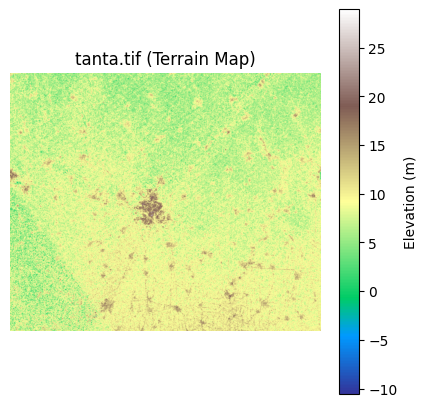

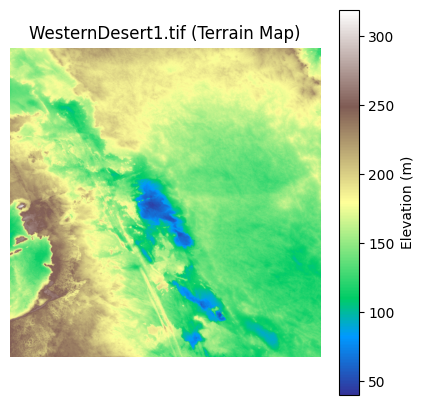

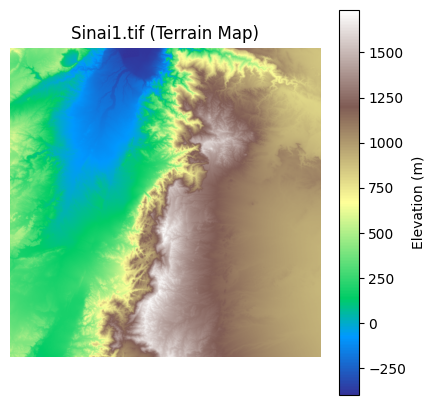

In [ ]:
# --- Function to show DEM as heatmap ---
def show_dem(filepath, title="DEM"):
    with rasterio.open(filepath) as src:
        dem = src.read(1)
        dem = np.where(dem == src.nodata, np.nan, dem)

    plt.figure(figsize=(5, 5))
    plt.imshow(dem, cmap='terrain')
    plt.title(title)
    plt.colorbar(label='Elevation (m)')
    plt.axis('off')
    plt.show()

# --- Visualize some DEMs ---
dems_to_show = ['tanta.tif', 'WesternDesert1.tif', 'Sinai1.tif']
for dem_file in dems_to_show:
    path = os.path.join(DEM_FOLDER, dem_file)
    if os.path.exists(path):
        show_dem(path, f"{dem_file} (Terrain Map)")
    else:
        print(f"{dem_file} not found.")

In [ ]:
# --- Prepare data ---
X = data_df.drop(columns=['filename','label'])
y = data_df['label']

In [ ]:
X.head()

,mean_elevation,std_elevation,min_elevation,max_slope,mean_flow_accum,max_flow_accum,percent_low_slope
0,6.000910,5.994186,5.927566,6.032924,7.1366,13.349266,5.991042
1,6.482893,6.197490,6.016284,6.032924,7.1366,13.349266,5.991042
2,5.994644,5.994278,5.943201,6.032924,7.1366,13.349266,5.991042
3,6.013238,6.007680,5.890622,6.032924,7.1366,13.349266,5.991042
4,6.008870,5.994408,5.962018,6.032924,7.1366,13.349266,5.991042


In [ ]:
y.head()

,label
0,0
1,0
2,0
3,0
4,0


In [ ]:
print(y.value_counts())

label
1    191
0    117
Name: count, dtype: int64


In [ ]:
# Train/Test Split --- stratified splitting to preserve class distribution
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)

KNN Classifier

https://www.geeksforgeeks.org/how-to-find-the-optimal-value-of-k-in-knn/

https://www.geeksforgeeks.org/k-nearest-neighbor-algorithm-in-python/

In [ ]:
# Hyperparameter tuning with cross-validation (4-fold)
# Odd k-values to avoid ties
param_grid = {'n_neighbors': range(1, 51, 2)}
knn = KNeighborsClassifier(weights='distance')
grid_search = GridSearchCV(knn, param_grid, cv=4, scoring='accuracy', n_jobs=-1)
grid_search.fit(X_train, y_train)

# Get best K value
optimal_k = grid_search.best_params_['n_neighbors']
print(f"Optimal K value: {optimal_k}")

# Train final model with best K using 5-fold CV
final_knn = KNeighborsClassifier(n_neighbors=optimal_k, weights='distance')
cv_scores = cross_val_score(final_knn, X_train, y_train, cv=4, scoring='accuracy')

# Print Cross-Validation Accuracy
print(f"\nCross-Validation Accuracy (Mean ± Std): {cv_scores.mean():.4f} ± {cv_scores.std():.4f}")

# Train model on full training+validation set
final_knn.fit(X_train, y_train)

# Evaluate on training set
train_acc = accuracy_score(y_train, final_knn.predict(X_train))

# Evaluate on test set
y_test_pred = final_knn.predict(X_test)
test_acc = accuracy_score(y_test, y_test_pred)

# Print Results
print(f"\nTraining Accuracy: {train_acc:.4f}")
print(f"Test Accuracy: {test_acc:.4f}")

# Model Evaluation
print("\nConfusion Matrix:\n", confusion_matrix(y_test, y_test_pred))
print("\nClassification Report:\n", classification_report(y_test, y_test_pred))

Optimal K value: 11

Cross-Validation Accuracy (Mean ± Std): 0.9310 ± 0.0263

Training Accuracy: 1.0000
Test Accuracy: 0.9355

Confusion Matrix:
 [[23  1]
 [ 3 35]]

Classification Report:
               precision    recall  f1-score   support

           0       0.88      0.96      0.92        24
           1       0.97      0.92      0.95        38

    accuracy                           0.94        62
   macro avg       0.93      0.94      0.93        62
weighted avg       0.94      0.94      0.94        62



In [ ]:
# Get classification report as a dictionary
report = classification_report(y_test, y_test_pred, target_names=["Not Flood Prone", "Flood Prone"], output_dict=True)

# Results for class 0 (Not Flood Prone)
class_0_metrics = report["Not Flood Prone"]
print("Class 0 - Not Flood Prone:")
print(f"  Precision: {class_0_metrics['precision']:.4f}")
print(f"  Recall:    {class_0_metrics['recall']:.4f}")
print(f"  F1-score:  {class_0_metrics['f1-score']:.4f}")
print(f"  Support:   {class_0_metrics['support']}")

# Results for class 1 (Flood Prone)
class_1_metrics = report["Flood Prone"]
print("\nClass 1 - Flood Prone:")
print(f"  Precision: {class_1_metrics['precision']:.4f}")
print(f"  Recall:    {class_1_metrics['recall']:.4f}")
print(f"  F1-score:  {class_1_metrics['f1-score']:.4f}")
print(f"  Support:   {class_1_metrics['support']}")

Class 0 - Not Flood Prone:
  Precision: 0.8846
  Recall:    0.9583
  F1-score:  0.9200
  Support:   24.0

Class 1 - Flood Prone:
  Precision: 0.9722
  Recall:    0.9211
  F1-score:  0.9459
  Support:   38.0


Linear Regression

https://www.geeksforgeeks.org/linear-regression-python-implementation/

In [ ]:
# Initialize Linear Regression model
model = LinearRegression()

# K-Fold Cross-Validation (5-fold)
kf = KFold(n_splits=5, shuffle=True, random_state=42)
cv_mae = -cross_val_score(model, X_train, y_train, cv=kf, scoring='neg_mean_absolute_error')
cv_mse = -cross_val_score(model, X_train, y_train, cv=kf, scoring='neg_mean_squared_error')
cv_r2 = cross_val_score(model, X_train, y_train, cv=kf, scoring='r2')

# Train the model on full training set
model.fit(X_train, y_train)

# Predictions on training and test sets
y_train_val_pred = model.predict(X_train)
y_test_pred = model.predict(X_test)

# Performance measures for training+validation set
train_val_mae = mean_absolute_error(y_train, y_train_val_pred)
train_val_mse = mean_squared_error(y_train, y_train_val_pred)
train_val_r2 = r2_score(y_train, y_train_val_pred)

# Performance measures for test set
test_mae = mean_absolute_error(y_test, y_test_pred)
test_mse = mean_squared_error(y_test, y_test_pred)
test_r2 = r2_score(y_test, y_test_pred)

# Print results
print("\nCross-Validation Performance (5-fold CV on Training+Validation Set):")
print(f"Mean Absolute Error: {cv_mae.mean():.4f} ± {cv_mae.std():.4f}")
print(f"Mean Squared Error: {cv_mse.mean():.4f} ± {cv_mse.std():.4f}")
print(f"R² Score: {cv_r2.mean():.4f} ± {cv_r2.std():.4f}")

print("\nTraining Performance:")
print(f"Mean Absolute Error: {train_val_mae:.4f}")
print(f"Mean Squared Error: {train_val_mse:.4f}")
print(f"R² Score: {train_val_r2:.4f}")

print("\nTest Performance:")
print(f"Mean Absolute Error: {test_mae:.4f}")
print(f"Mean Squared Error: {test_mse:.4f}")
print(f"R² Score: {test_r2:.4f}")


Cross-Validation Performance (5-fold CV on Training+Validation Set):
Mean Absolute Error: 0.2445 ± 0.0345
Mean Squared Error: 0.0933 ± 0.0283
R² Score: 0.5974 ± 0.1147

Training Performance:
Mean Absolute Error: 0.2321
Mean Squared Error: 0.0825
R² Score: 0.6490

Test Performance:
Mean Absolute Error: 0.2390
Mean Squared Error: 0.0846
R² Score: 0.6436


Logistic Regression

https://www.geeksforgeeks.org/ml-logistic-regression-using-python/

In [ ]:
# Train the Logistic Regression model
model = LogisticRegression(max_iter=1000)  # max_iter added to avoid convergence issues
model.fit(X_train, y_train)

# ===== Training evaluation =====
y_train_pred = model.predict(X_train)
train_acc = accuracy_score(y_train, y_train_pred)
print(f"\nTraining Accuracy: {train_acc*100:.2f}%")
print("\nTraining Confusion Matrix:\n", confusion_matrix(y_train, y_train_pred))
print("\nTraining Classification Report:\n", classification_report(
    y_train, y_train_pred, target_names=["Not Flood Prone", "Flood Prone"]))

# Per-class metrics (Training)
train_report = classification_report(
    y_train, y_train_pred, target_names=["Not Flood Prone", "Flood Prone"], output_dict=True)

print("\n--- Per-Class Metrics (Training) ---")
for label in ["Not Flood Prone", "Flood Prone"]:
    print(f"{label}: Precision={train_report[label]['precision']:.4f}, "
          f"Recall={train_report[label]['recall']:.4f}, "
          f"F1-score={train_report[label]['f1-score']:.4f}, "
          f"Support={train_report[label]['support']}")


Training Accuracy: 89.84%

Training Confusion Matrix:
 [[ 81  12]
 [ 13 140]]

Training Classification Report:
                  precision    recall  f1-score   support

Not Flood Prone       0.86      0.87      0.87        93
    Flood Prone       0.92      0.92      0.92       153

       accuracy                           0.90       246
      macro avg       0.89      0.89      0.89       246
   weighted avg       0.90      0.90      0.90       246


--- Per-Class Metrics (Training) ---
Not Flood Prone: Precision=0.8617, Recall=0.8710, F1-score=0.8663, Support=93.0
Flood Prone: Precision=0.9211, Recall=0.9150, F1-score=0.9180, Support=153.0


In [ ]:
# ===== Testing evaluation =====
y_test_pred = model.predict(X_test)
test_acc = accuracy_score(y_test, y_test_pred)
print(f"\nTest Accuracy: {test_acc*100:.2f}%")
print("\nTest Confusion Matrix:\n", confusion_matrix(y_test, y_test_pred))
print("\nTest Classification Report:\n", classification_report(
    y_test, y_test_pred, target_names=["Not Flood Prone", "Flood Prone"]))

# Per-class metrics (Testing)
test_report = classification_report(
    y_test, y_test_pred, target_names=["Not Flood Prone", "Flood Prone"], output_dict=True)

print("\n--- Per-Class Metrics (Testing) ---")
for label in ["Not Flood Prone", "Flood Prone"]:
    print(f"{label}: Precision={test_report[label]['precision']:.4f}, "
          f"Recall={test_report[label]['recall']:.4f}, "
          f"F1-score={test_report[label]['f1-score']:.4f}, "
          f"Support={test_report[label]['support']}")


Test Accuracy: 90.32%

Test Confusion Matrix:
 [[22  2]
 [ 4 34]]

Test Classification Report:
                  precision    recall  f1-score   support

Not Flood Prone       0.85      0.92      0.88        24
    Flood Prone       0.94      0.89      0.92        38

       accuracy                           0.90        62
      macro avg       0.90      0.91      0.90        62
   weighted avg       0.91      0.90      0.90        62


--- Per-Class Metrics (Testing) ---
Not Flood Prone: Precision=0.8462, Recall=0.9167, F1-score=0.8800, Support=24.0
Flood Prone: Precision=0.9444, Recall=0.8947, F1-score=0.9189, Support=38.0


RandomForest Classifier

https://www.geeksforgeeks.org/random-forest-algorithm-in-machine-learning/

In [ ]:
# ===== Cross-Validation =====
rf_classifier_cv = RandomForestClassifier(n_estimators=100, random_state=42)
cv = KFold(n_splits=5, shuffle=True, random_state=42)
cv_scores = cross_val_score(rf_classifier_cv, X_train, y_train, cv=cv, scoring='accuracy')
print(f"\nRandom Forest Cross-Validation Accuracy: {cv_scores.mean():.4f} ± {cv_scores.std():.4f}")

# ===== Train Final Model =====
rf_classifier = RandomForestClassifier(
    n_estimators=100,
    max_depth=15,              # Restrict depth
    min_samples_split=5,       # Reduce splitting frequency
    min_samples_leaf=2,        # Prevent small leaf nodes
    class_weight="balanced",
    random_state=42
)
rf_classifier.fit(X_train, y_train)

# ===== Training Evaluation =====
y_pred_train = rf_classifier.predict(X_train)
train_acc = accuracy_score(y_train, y_pred_train)
print(f"\nTraining Accuracy: {train_acc:.4f}")
print("\nTraining Confusion Matrix:\n", confusion_matrix(y_train, y_pred_train))
print("\nTraining Classification Report:\n", classification_report(
    y_train, y_pred_train, target_names=["Not Flood Prone", "Flood Prone"]))

# Per-class metrics (Training)
train_report = classification_report(
    y_train, y_pred_train, target_names=["Not Flood Prone", "Flood Prone"], output_dict=True)
print("\n--- Per-Class Metrics (Training) ---")
for label in ["Not Flood Prone", "Flood Prone"]:
    print(f"{label}: Precision={train_report[label]['precision']:.4f}, "
          f"Recall={train_report[label]['recall']:.4f}, "
          f"F1-score={train_report[label]['f1-score']:.4f}, "
          f"Support={train_report[label]['support']}")


Random Forest Cross-Validation Accuracy: 0.9553 ± 0.0416

Training Accuracy: 0.9919

Training Confusion Matrix:
 [[ 93   0]
 [  2 151]]

Training Classification Report:
                  precision    recall  f1-score   support

Not Flood Prone       0.98      1.00      0.99        93
    Flood Prone       1.00      0.99      0.99       153

       accuracy                           0.99       246
      macro avg       0.99      0.99      0.99       246
   weighted avg       0.99      0.99      0.99       246


--- Per-Class Metrics (Training) ---
Not Flood Prone: Precision=0.9789, Recall=1.0000, F1-score=0.9894, Support=93.0
Flood Prone: Precision=1.0000, Recall=0.9869, F1-score=0.9934, Support=153.0


In [ ]:
# ===== Test Evaluation =====
y_pred_test = rf_classifier.predict(X_test)
test_acc = accuracy_score(y_test, y_pred_test)
print(f"\nTest Accuracy: {test_acc:.4f}")
print("\nTest Confusion Matrix:\n", confusion_matrix(y_test, y_pred_test))
print("\nTest Classification Report:\n", classification_report(
    y_test, y_pred_test, target_names=["Not Flood Prone", "Flood Prone"]))

# Per-class metrics (Testing)
test_report = classification_report(
    y_test, y_pred_test, target_names=["Not Flood Prone", "Flood Prone"], output_dict=True)
print("\n--- Per-Class Metrics (Testing) ---")
for label in ["Not Flood Prone", "Flood Prone"]:
    print(f"{label}: Precision={test_report[label]['precision']:.4f}, "
          f"Recall={test_report[label]['recall']:.4f}, "
          f"F1-score={test_report[label]['f1-score']:.4f}, "
          f"Support={test_report[label]['support']}")

# ===== Sample Prediction =====
sample = X_test.iloc[0:1]
prediction = rf_classifier.predict(sample)
print(f"\nRandom Forest Prediction: {'Not Flood_Prone' if prediction[0] == 0 else 'Flood_Prone'}")


Test Accuracy: 0.9355

Test Confusion Matrix:
 [[23  1]
 [ 3 35]]

Test Classification Report:
                  precision    recall  f1-score   support

Not Flood Prone       0.88      0.96      0.92        24
    Flood Prone       0.97      0.92      0.95        38

       accuracy                           0.94        62
      macro avg       0.93      0.94      0.93        62
   weighted avg       0.94      0.94      0.94        62


--- Per-Class Metrics (Testing) ---
Not Flood Prone: Precision=0.8846, Recall=0.9583, F1-score=0.9200, Support=24.0
Flood Prone: Precision=0.9722, Recall=0.9211, F1-score=0.9459, Support=38.0

Random Forest Prediction: Not Flood_Prone


Decision Tree

https://www.datacamp.com/tutorial/decision-tree-classification-python

In [ ]:
# Create Decision Tree Classifier
dt_classifier = DecisionTreeClassifier(
    max_depth=15,            # Limit tree depth to prevent overfitting
    min_samples_split=5,     # Reduce splitting frequency
    min_samples_leaf=1,      # Prevent small leaf nodes
    class_weight="balanced", # Handle class imbalance
    random_state=42
)

# Train the Decision Tree model
dt_classifier.fit(X_train, y_train)

# Predictions for training set
y_train_pred = dt_classifier.predict(X_train)

# Predictions for test set
y_test_pred = dt_classifier.predict(X_test)

# Training evaluation
print("===== Training Set Results =====")
print("Accuracy:", accuracy_score(y_train, y_train_pred))
print("Confusion Matrix:\n", confusion_matrix(y_train, y_train_pred))
print("Classification Report:\n", classification_report(
    y_train, y_train_pred, target_names=["Not Flood Prone (0)", "Flood Prone (1)"]
))

# Testing evaluation
print("\n===== Testing Set Results =====")
print("Accuracy:", accuracy_score(y_test, y_test_pred))
print("Confusion Matrix:\n", confusion_matrix(y_test, y_test_pred))
print("Classification Report:\n", classification_report(
    y_test, y_test_pred, target_names=["Not Flood Prone (0)", "Flood Prone (1)"]
))

===== Training Set Results =====
Accuracy: 0.9878048780487805
Confusion Matrix:
 [[ 91   2]
 [  1 152]]
Classification Report:
                      precision    recall  f1-score   support

Not Flood Prone (0)       0.99      0.98      0.98        93
    Flood Prone (1)       0.99      0.99      0.99       153

           accuracy                           0.99       246
          macro avg       0.99      0.99      0.99       246
       weighted avg       0.99      0.99      0.99       246


===== Testing Set Results =====
Accuracy: 0.9354838709677419
Confusion Matrix:
 [[22  2]
 [ 2 36]]
Classification Report:
                      precision    recall  f1-score   support

Not Flood Prone (0)       0.92      0.92      0.92        24
    Flood Prone (1)       0.95      0.95      0.95        38

           accuracy                           0.94        62
          macro avg       0.93      0.93      0.93        62
       weighted avg       0.94      0.94      0.94        62



In [ ]:
X_train.columns #9 inputs

Index(['mean_elevation', 'std_elevation', 'min_elevation', 'max_slope',
       'mean_flow_accum', 'max_flow_accum', 'percent_low_slope'],
      dtype='object')

Neural Network Architecture:

Input Layer: 8 features (as given in the dataset)

Hidden Layer 1: 4 neurons, Sigmoid activation

Output Layer: 1 neuron, Sigmoid activation (binary classification)

Loss Function: binary_crossentropy (for binary classification)

Optimizer: adam (adaptive learning)

Metrics: accuracy

Sigmoid Activation: Helps keep outputs between 0 and 1 for probability-based classification.

one Hidden Layer: Helps capture complex patterns in attack/normal classifications.

Adam Optimizer: Adaptive learning rate makes training faster.

Batch Normalization: Standardization of inputs ensures stable learning.

In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Input
from tensorflow.keras.callbacks import EarlyStopping

# Define the Neural Network model (using Input to avoid the warning)
model = Sequential([
    Input(shape=(X_train.shape[1],)),  # Explicit input layer
    Dense(4, activation='relu'),    # First hidden layer
    Dense(1, activation='sigmoid')     # Output layer for binary classification
])

# Compile the model
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Early stopping callback
early_stop = EarlyStopping(
    monitor='val_loss',    # Track validation loss
    patience=5,            # Stop if no improvement for 5 epochs
    restore_best_weights=True  # Roll back to best weights
)

# Train the model
history = model.fit(
    X_train, y_train,
    epochs=50,
    batch_size=32,
    validation_split=0.2,
    verbose=1,
    callbacks=[early_stop]
)

# Evaluate the model
test_loss, test_accuracy = model.evaluate(X_test, y_test)
print(f"Test Accuracy: {test_accuracy:.4f}")

# Predict on test data
y_pred = (model.predict(X_test) > 0.5).astype("int32")

Epoch 1/50
7/7 ━━━━━━━━━━━━━━━━━━━━ 2s 51ms/step - accuracy: 0.6195 - loss: 0.6838 - val_accuracy: 0.6000 - val_loss: 0.6760
Epoch 2/50
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - accuracy: 0.6364 - loss: 0.6723 - val_accuracy: 0.6000 - val_loss: 0.6717
Epoch 3/50
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - accuracy: 0.6083 - loss: 0.6673 - val_accuracy: 0.6000 - val_loss: 0.6679
Epoch 4/50
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - accuracy: 0.6512 - loss: 0.6567 - val_accuracy: 0.6000 - val_loss: 0.6637
Epoch 5/50
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - accuracy: 0.6525 - loss: 0.6497 - val_accuracy: 0.6000 - val_loss: 0.6606
Epoch 6/50
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - accuracy: 0.6551 - loss: 0.6420 - val_accuracy: 0.6000 - val_loss: 0.6587
Epoch 7/50
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - accuracy: 0.5861 - loss: 0.6625 - val_accuracy: 0.6000 - val_loss: 0.6578
Epoch 8/50
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - accuracy: 0.6347 - loss: 0.6418 - val_accuracy: 0.6000 - val_loss: 0.6577


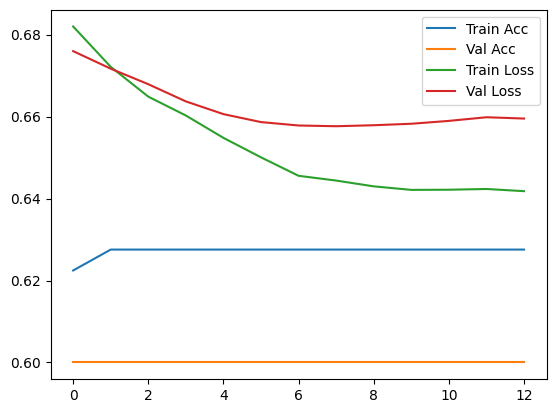

In [ ]:
#Check overfitting
plt.plot(history.history['accuracy'], label='Train Acc')
plt.plot(history.history['val_accuracy'], label='Val Acc')
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.legend()
plt.show()

SVM

https://www.geeksforgeeks.org/implementing-svm-from-scratch-in-python/

In [ ]:
class SVM:
    def __init__(self, learning_rate=0.01, lambda_param=0.01, n_iters=500):
        self.lr = learning_rate
        self.lambda_param = lambda_param
        self.n_iters = n_iters
        self.w = None
        self.b = None

    def fit(self, X, y):
        n_samples, n_features = X.shape
        y_ = np.where(y <= 0, -1, 1)  # Convert labels to -1 and 1

        self.w = np.zeros(n_features)
        self.b = 0

        for _ in range(self.n_iters):
            for idx, x_i in enumerate(X):
                condition = y_[idx] * (np.dot(x_i, self.w) - self.b) >= 1
                if condition:
                    self.w -= self.lr * (2 * self.lambda_param * self.w)
                else:
                    self.w -= self.lr * (2 * self.lambda_param * self.w - np.dot(x_i, y_[idx]))
                    self.b -= self.lr * y_[idx]

    def predict(self, X):
        approx = np.dot(X, self.w) - self.b
        return np.sign(approx)

In [ ]:
# Train the Sklearn SVM with Sigmoid Kernel
clf = SVC(kernel='sigmoid')
clf.fit(X_train, y_train)

# Predictions using Sklearn SVM
sklearn_predictions = clf.predict(X_test)
print("Sklearn SVM Predictions:", sklearn_predictions)

Sklearn SVM Predictions: [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]


In [ ]:
from imblearn.over_sampling import SMOTE
smote = SMOTE(random_state=42)
X_train_bal, y_train_bal = smote.fit_resample(X_train, y_train)
clf.fit(X_train_bal, y_train_bal)

SVC(kernel='sigmoid')

In [ ]:
from sklearn.svm import SVC
clf = SVC(kernel='sigmoid', class_weight='balanced', random_state=42)

In [ ]:
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report

# 1. Create the model
clf = SVC(kernel='sigmoid', class_weight='balanced', random_state=42)

# 2. Train the model
clf.fit(X_train, y_train)

# 3. --- Predictions for full dataset ---
y_pred = clf.predict(X_test)

accuracy = accuracy_score(y_test, y_pred)
print(f"SVM Accuracy: {accuracy:.4f}")
print("\nConfusion Matrix:")
print(confusion_matrix(y_test, y_pred))
print("\nClassification Report (per class):")
print(classification_report(
    y_test, y_pred, target_names=["Not Flood Prone (0)", "Flood Prone (1)"]
))

# 4. --- Training results ---
y_train_pred = clf.predict(X_train)
print(f"\nTraining Accuracy: {accuracy_score(y_train, y_train_pred):.4f}")
print("\nTraining Confusion Matrix:")
print(confusion_matrix(y_train, y_train_pred))
print("\nTraining Classification Report:")
print(classification_report(
    y_train, y_train_pred, target_names=["Not Flood Prone (0)", "Flood Prone (1)"]
))

# 5. --- Testing results ---
y_test_pred = clf.predict(X_test)
print(f"\nTest Accuracy: {accuracy_score(y_test, y_test_pred):.4f}")
print("\nTest Confusion Matrix:")
print(confusion_matrix(y_test, y_test_pred))
print("\nTest Classification Report:")
print(classification_report(
    y_test, y_test_pred, target_names=["Not Flood Prone (0)", "Flood Prone (1)"]
))

SVM Accuracy: 0.6129

Confusion Matrix:
[[ 0 24]
 [ 0 38]]

Classification Report (per class):
                     precision    recall  f1-score   support

Not Flood Prone (0)       0.00      0.00      0.00        24
    Flood Prone (1)       0.61      1.00      0.76        38

           accuracy                           0.61        62
          macro avg       0.31      0.50      0.38        62
       weighted avg       0.38      0.61      0.47        62


Training Accuracy: 0.6220

Training Confusion Matrix:
[[  0  93]
 [  0 153]]

Training Classification Report:
                     precision    recall  f1-score   support

Not Flood Prone (0)       0.00      0.00      0.00        93
    Flood Prone (1)       0.62      1.00      0.77       153

           accuracy                           0.62       246
          macro avg       0.31      0.50      0.38       246
       weighted avg       0.39      0.62      0.48       246


Test Accuracy: 0.6129

Test Confusion Matrix:
[[ 0 24]


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning:

Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.

/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning:

Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.

/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning:

Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.

/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning:

Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.

/usr/local/lib/p

In [ ]:
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
from imblearn.over_sampling import SMOTE
from sklearn.model_selection import train_test_split

# --- Split data first ---
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# --- Apply SMOTE only to training set ---
smote = SMOTE(random_state=42)
X_train_res, y_train_res = smote.fit_resample(X_train, y_train)

# --- Train the model ---
clf = SVC(kernel='sigmoid', class_weight='balanced', random_state=42)
clf.fit(X_train_res, y_train_res)

# --- Training results ---
y_train_pred = clf.predict(X_train_res)
print(f"\nTraining Accuracy: {accuracy_score(y_train_res, y_train_pred):.4f}")
print(confusion_matrix(y_train_res, y_train_pred))
print(classification_report(
    y_train_res, y_train_pred, target_names=["Not Flood Prone (0)", "Flood Prone (1)"]
))

# --- Testing results ---
y_test_pred = clf.predict(X_test)
print(f"\nTest Accuracy: {accuracy_score(y_test, y_test_pred):.4f}")
print(confusion_matrix(y_test, y_test_pred))
print(classification_report(
    y_test, y_test_pred, target_names=["Not Flood Prone (0)", "Flood Prone (1)"]
))


Training Accuracy: 0.3377
[[ 91  63]
 [141  13]]
                     precision    recall  f1-score   support

Not Flood Prone (0)       0.39      0.59      0.47       154
    Flood Prone (1)       0.17      0.08      0.11       154

           accuracy                           0.34       308
          macro avg       0.28      0.34      0.29       308
       weighted avg       0.28      0.34      0.29       308


Test Accuracy: 0.2258
[[10 15]
 [33  4]]
                     precision    recall  f1-score   support

Not Flood Prone (0)       0.23      0.40      0.29        25
    Flood Prone (1)       0.21      0.11      0.14        37

           accuracy                           0.23        62
          macro avg       0.22      0.25      0.22        62
       weighted avg       0.22      0.23      0.20        62



In [ ]:
# Train the Sklearn SVM with rbf Kernel
clf = SVC(kernel='rbf')
clf.fit(X_train, y_train)

# Predictions using Sklearn SVM
sklearn_predictions = clf.predict(X_test)
print("Sklearn SVM Predictions:", sklearn_predictions)

Sklearn SVM Predictions: [1 1 1 1 1 1 1 1 0 1 1 0 1 1 1 1 0 1 1 0 1 1 1 0 1 1 1 1 1 1 1 0 1 1 1 1 0
 1 1 1 0 1 1 0 1 1 1 1 1 1 1 1 1 1 1 1 1 0 1 1 1 1]


In [ ]:
# Predictions on test set
y_pred = clf.predict(X_test)

# Calculate accuracy
accuracy = accuracy_score(y_test, y_pred)
print(f"Sklearn SVM Accuracy: {accuracy:.4f}")

Sklearn SVM Accuracy: 0.7581
